In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

### Get reference scores

In [2]:
!pip install h5py

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import h5py

f = h5py.File('contrib_test_2_v2.h5', 'r')

locations = f['locations'][:]
scores    = f['contribution_scores'][:]

# score axis names: ['windows', 'tokens', 'length', 'cells']

start = f'chr{locations[0][0] + 1}:{locations[0][1]}-{locations[0][2]}'
stop = f'chr{locations[-1][0] + 1}:{locations[-1][1]}-{locations[-1][2]}'
    
print(start, stop)
scores.shape

chr9:13262450-13262650 chr9:13572350-13572550


(6199, 4, 200, 3)

### Get model and batch of sequences

In [6]:
# if os.path.isdir('./artifacts'):
#     shutil.rmtree('./artifacts')
# hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
# unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



In [7]:
def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0.25
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

In [8]:
chunk_idx = 35
chunk_name = 'chunk_' + str(chunk_idx).zfill(2)
#print(chunk_name)
chunk_path = 'df_chunks/' + chunk_name + '.txt'

line_dict = {} 
with open(chunk_path, 'r') as f:
    for line in f:
        ID, sequence = line.lstrip('>::').rstrip('\n').split('\t')
        line_dict[ID] = sequence.upper()
temp_df = pd.DataFrame(line_dict.items(), columns=['ID', 'nt_sequence'])
temp_df['seq_len'] = temp_df.apply(lambda x: len(x['nt_sequence']), axis=1)

temp_df

,ID,nt_sequence,seq_len
0,chr1:0-200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
1,chr9:7468300-7468500,CTGGAGGAATCAGTTTATTTGTTGTGAATGCTTTCGAGATGGGATT...,200
2,chr9:7468350-7468550,AAACCTATTAATTCAGCTATTATTTATTGAGTGGCTGCTATGTGTG...,200
3,chr9:7468400-7468600,GCTGTGAAAAAAAACAGTGAAGCGGGCTCAGTCCCTATTCTCAGCA...,200
4,chr9:7468450-7468650,GTGGTCTAGAAGGAGAGAGAGATTTTTGGAAGAGGTCATCCAAATT...,200
...,...,...,...
999995,chr9:57468000-57468200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999996,chr9:57468050-57468250,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999997,chr9:57468100-57468300,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999998,chr9:57468150-57468350,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200


In [41]:
start_idx, stop_idx = temp_df[temp_df['ID'] == start].index.item(), temp_df[temp_df['ID'] == stop].index.item()

batch_df = temp_df[start_idx : stop_idx + 1].reset_index(drop=True)

example_batch = df_to_onehot_tensor(batch_df)

start_idx, stop_idx

  0%|          | 0/6199 [00:00<?, ?it/s]

(115884, 122082)

In [42]:
batch_df

,ID,nt_sequence,seq_len
0,chr9:13262450-13262650,AAAAAAATAATAATAAAAATTAAAAAGAGTTCTCTTCATAGGAGGA...,200
1,chr9:13262500-13262700,AATGTTCTTTCTTCAAACTCTACTAGAAAAATTCAGCCAAGTATAC...,200
2,chr9:13262550-13262750,TAAAACTTTAATGTACCACTAAAAAAACAGAAATAGAGTCTATATA...,200
3,chr9:13262600-13262800,ATACACCAAGATGAAAAAAAGATGAACAAAAAATACTCTAGCAATC...,200
4,chr9:13262650-13262850,AGAGGTTAGGAATGAGAAAAAAAGGAAAAAGGAGAAGCCATAGTAA...,200
...,...,...,...
6194,chr9:13572150-13572350,AGTCCTTTAGCCTCTCTGAAACTTGGGTTTCTCATCTGCAAAATGG...,200
6195,chr9:13572200-13572400,GAAATTATATTGACTCTTGCCAATTCACAGGCTTGTTGTAAGGAAC...,200
6196,chr9:13572250-13572450,TAATCTTTATTAACTTTAGATCACTATACAAATGTTCATTATTATA...,200
6197,chr9:13572300-13572500,TTATTTGTGTTACTGCTTTGTAAACCACACAAGGCTATATGATTGC...,200


In [31]:
#example_batch = example_batch[:500, ...]
example_batch.shape

torch.Size([6199, 4, 200])

### Function drafts

In [49]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 
        

def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15,
                      adaptive_sampling=False,
                      adaptive_spacing=False
                     ):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    if adaptive_sampling:
        if num_steps == 100: 
            sample_ns = np.flip((np.arange(0, num_steps)**0.615).astype(int)).clip(min=2)
        elif num_steps == 50:
            sample_ns = np.flip((np.arange(0, num_steps)**0.77).astype(int)).clip(min=2)
        else:
            print('Not possible to do adaptive sampling with this num_steps yet')
    else:
        sample_ns = [num_samples for i in range(0, num_steps + 1)]
        
    if adaptive_spacing:
        slope_coefficients = 1 / np.flip(20**(np.linspace(0, 1, num_steps)))
        slope_coefficients = slope_coefficients / slope_coefficients.max()
    else:
        slope_coefficients = [i / num_steps for i in range(1, num_steps + 1)]
    
    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps):
            point_thetas = slope_coefficients[i] * target_thetas
            num_samples = sample_ns[i]
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1, 1, 1])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
        
    return theta_factor * torch.cat(all_gradients).cpu()
    # return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()


def batch_to_contributions(onehot_sequences,
                           model,
                           model_output_len=3,
                           seq_len=200,
                           num_steps=50,
                           num_samples=20,
                           theta_factor=15,
                           eval_batch_size=1040,
                           adaptive_sampling=False,
                           adaptive_spacing=False):
    
    extended_contributions = []
    for i in range(model_output_len):
        predictor = mpra_predictor(model=model, pred_idx=i, ini_in_len=seq_len).cuda()
        extended_contributions.append(isg_contributions(onehot_sequences, predictor,
                                                        num_steps = num_steps,
                                                        num_samples=num_samples,
                                                        theta_factor=theta_factor,
                                                        eval_batch_size=eval_batch_size,
                                                        adaptive_sampling=adaptive_sampling,
                                                        adaptive_spacing=adaptive_spacing
                                                       ))
        
    #return torch.stack(extended_contributions, dim=-1)    
    return torch.stack(extended_contributions)  

In [79]:
%%time
torch.manual_seed(321)
np.random.seed(321)

random_idxs = np.random.choice(batch_df[~batch_df['nt_sequence'].str.contains('N')].index.tolist(), size=1000, replace=False)
test_batch = example_batch[random_idxs, ...]
test_scores = scores[random_idxs, ...]

result_dict = {}

# #--- Adaptive spacing
# n_steps   = 50
# n_samples = 20
# adaptive_sampling = False
# adaptive_spacing  = True

# out_contributions = batch_to_contributions(onehot_sequences=test_batch,
#                                            model=model,
#                                            num_steps=n_steps,
#                                            num_samples=n_samples,
#                                            adaptive_sampling=adaptive_sampling,
#                                            adaptive_spacing=adaptive_spacing)
# result_dict['Adaptive spacing'] = out_contributions

CPU times: user 7.53 ms, sys: 8.01 ms, total: 15.5 ms
Wall time: 13.6 ms


In [80]:
%%time

#--- Standard medium quality
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict['Standard medium quality'] = out_contributions

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4min 54s, sys: 1.06 s, total: 4min 55s
Wall time: 4min 55s


In [81]:
%%time

#--- Adaptive sampling (Needs re-batching)
n_steps   = 100
n_samples = 20                 # Not used in this option
adaptive_sampling = True
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict['Adaptive sampling'] = out_contributions

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4min 58s, sys: 1.19 s, total: 4min 59s
Wall time: 4min 58s


In [82]:
%%time

#--- High quality rerun
n_steps   = 100
n_samples = 20             
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict['High quality rerun'] = out_contributions

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 9min 48s, sys: 1.25 s, total: 9min 49s
Wall time: 9min 48s


In [83]:
%%time

#--- Adaptive sampling half
n_steps   = 50
n_samples = 20                 # Not used in this option
adaptive_sampling = True
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict['Adaptive sampling half'] = out_contributions

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 1.01 s, total: 2min 43s
Wall time: 2min 42s


In [113]:
for key in result_dict.keys():
    x = result_dict[key].flatten().numpy()
    y = torch.Tensor(test_scores).permute(3, 0, 1, 2).flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    print(key, pearson)

Standard medium quality 0.91
Adaptive sampling 0.93
High quality rerun 0.94
Adaptive sampling half 0.91


In [66]:
torch.manual_seed(88)
np.random.seed(88)

result_dict_2 = {}

#--- Standard medium quality
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict_2['Standard medium quality'] = out_contributions


#--- Adaptive spacing
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = True

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict_2['Adaptive spacing'] = out_contributions


#--- Adaptive sampling (Needs re-batching)
n_steps   = 100
n_samples = 20                 # Not used in this option
adaptive_sampling = True
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)
result_dict_2['Adaptive sampling'] = out_contributions

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
for key in result_dict_2.keys():
    x = result_dict_2[key].flatten().numpy()
    y = torch.Tensor(test_scores).permute(3, 0, 1, 2).flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    print(key, pearson)

Standard medium quality 0.91
Adaptive spacing 0.91
Adaptive sampling 0.93


In [68]:
%%time

#--- Standard medium quality
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 26s, sys: 685 ms, total: 2min 27s
Wall time: 2min 27s


In [69]:
%%time

#--- Adaptive spacing
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = True

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 26s, sys: 709 ms, total: 2min 27s
Wall time: 2min 27s


Standard medium quality 0.93


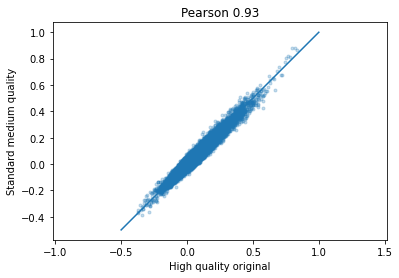

Adaptive sampling 0.95


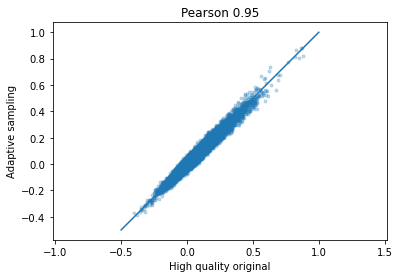

High quality rerun 0.95


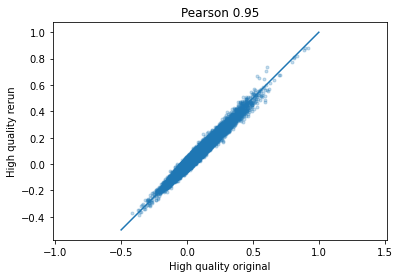

Adaptive sampling half 0.93


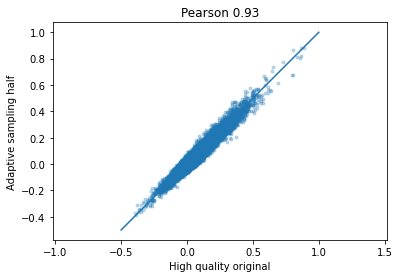

In [114]:
y = torch.Tensor(test_scores).permute(3, 0, 1, 2) * test_batch.repeat(3,1,1,1)
y = y.sum(dim=2).flatten().numpy()
for key in result_dict.keys():
    x = result_dict[key] * test_batch.repeat(3,1,1,1)
    x = x.sum(dim=2).flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    print(key, pearson)
    
    plt.scatter(x=x, y=y, alpha=0.25, marker='.')
    plt.plot([-0.5, 1], [-0.5, 1])
    plt.axis('equal')
    plt.xlabel('High quality original')
    plt.ylabel(key)
    plt.title(f'Pearson {pearson}')
    plt.show()

# print('')
# for key in result_dict_2.keys():
#     x = result_dict_2[key] * test_batch.repeat(3,1,1,1)
#     x = x.sum(dim=2).flatten().numpy()
#     pearson = np.round(np.corrcoef(x,y)[0,1], 2)
#     print(key, pearson)
#     plt.scatter(x=x, y=y, alpha=0.25, marker='.')
#     plt.plot([-0.5, 1], [-0.5, 1])
#     plt.axis('equal')
#     plt.xlabel('High quality original')
#     plt.ylabel(key)
#     plt.title(f'Pearson {pearson}')
#     plt.show()

In [ ]:
y = torch.Tensor(test_scores).permute(3, 0, 1, 2)
y = y.flatten().numpy()
for key in result_dict.keys():
    x = result_dict[key]
    x = x.flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    print(key, pearson)
    
    plt.scatter(x=x, y=y, alpha=0.25, marker='.')
    plt.plot([0, 1], [0, 1])
    plt.axis('equal')
    plt.xlabel('High quality original')
    plt.ylabel(key)
    plt.title(f'Pearson {pearson}')
    plt.show()

print('')
for key in result_dict_2.keys():
    x = result_dict_2[key] * test_batch.repeat(3,1,1,1)
    x = x.flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    print(key, pearson)
    plt.scatter(x=x, y=y, alpha=0.25, marker='.')
    plt.plot([0, 1], [0, 1])
    plt.axis('equal')
    plt.xlabel('High quality original')
    plt.ylabel(key)
    plt.title(f'Pearson {pearson}')
    plt.show()

In [76]:
torch.Tensor(test_scores).permute(3, 0, 1, 2).shape

torch.Size([3, 500, 4, 200])

In [91]:
def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      max_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15,
                      adaptive_sampling=False
                     ):
    
    batch_size = eval_batch_size // (max_samples - 3)
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    slope_coefficients = [i / num_steps for i in range(1, num_steps + 1)]
    if adaptive_sampling:
        sneaky_exponent = np.log(max_samples - 3) / np.log(num_steps)
        sample_ns = np.flip((np.arange(0, num_steps)**sneaky_exponent).astype(int)).clip(min=2)
    else:
        sample_ns = [max_samples for i in range(0, num_steps + 1)]       
      
    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps):
            point_thetas = slope_coefficients[i] * target_thetas
            num_samples = sample_ns[i]
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1, 1, 1])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
        
    return theta_factor * torch.cat(all_gradients).cpu()


def batch_to_contributions(onehot_sequences,
                           model,
                           model_output_len=3,
                           seq_len=200,
                           num_steps=50,
                           max_samples=20,
                           theta_factor=15,
                           eval_batch_size=1040,
                           adaptive_sampling=False):
    
    extended_contributions = []
    for i in range(model_output_len):
        predictor = mpra_predictor(model=model, pred_idx=i, ini_in_len=seq_len).cuda()
        extended_contributions.append(isg_contributions(onehot_sequences, predictor,
                                                        num_steps = num_steps,
                                                        max_samples=max_samples,
                                                        theta_factor=theta_factor,
                                                        eval_batch_size=eval_batch_size,
                                                        adaptive_sampling=adaptive_sampling
                                                       ))
        
    return torch.stack(extended_contributions, dim=-1) 

In [112]:
%%time

#--- Adaptive sampling
n_steps   = 100
n_samples = 20
adaptive_sampling = True

out_contributions = batch_to_contributions(onehot_sequences=test_batch[:20,...],
                                           model=model,
                                           num_steps=n_steps,
                                           max_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 6.47 s, sys: 692 ms, total: 7.16 s
Wall time: 7.14 s


In [110]:
x = out_contributions.flatten().numpy()
y = torch.Tensor(test_scores)[:20,...].flatten().numpy()
np.round(np.corrcoef(x,y)[0,1], 2)

0.92

In [106]:
out_contributions.shape, torch.Tensor(test_scores).shape

(torch.Size([20, 4, 200, 3]), torch.Size([1000, 4, 200, 3]))